In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image, ImageOps
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import math
from sklearn.manifold import TSNE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/DLS-1/Project"

SRC_ALIGNED_DIR = os.path.join(BASE_DIR, "Aligned_2")
ALIGNED_DIR     = "/content/Aligned_2"

TRAIN_CSV       = os.path.join(BASE_DIR, "train_celeba.csv")
VAL_CSV         = os.path.join(BASE_DIR, "val_celeba.csv")

VAL_REPORT_CSV  = os.path.join(BASE_DIR, "val_report_celeba_arcface_loss.csv")
MODEL_PARAMS_PT = os.path.join(BASE_DIR, "model_params_resnet18_arcface_loss.pt")

## Шаг 1 "Подготовка данных"
* Копируем папку с ранее вырезанными и выровненными лицами из Google Drive в локальное расположения Google Colab. Иначе очень медленно работает Dataset.
* Определяем класс FaceDataset, который кроме изображения с label, дополнительно возвращает и person_id. В режиме обучения применяем ряд аугментаций - они понятны, проговаривать не буду. RandomHorizontalFlip НЕ используется, т.к. для лиц людей лево и право играет роль. Нормализация выполняется по значениям, рекомендуемым для предобученной модели ResNet18, которая будет использоваться ниже.
* Создаем train и val датасеты и даталоадеры. Разбивка всей обучающей выборки  на train и val части делалась ранее. Размер BATCH_SIZE задаем 32 - рекомендуемое для задачи значение. Выборку train перемешиваем. Всё стандартно.

In [ ]:
os.makedirs(ALIGNED_DIR, exist_ok=True)

shutil.copytree(SRC_ALIGNED_DIR, ALIGNED_DIR, dirs_exist_ok=True)

'/content/Aligned_2'

In [ ]:
class FaceDataset(Dataset):
    def __init__(self, img_dir, df, train=True):
        self.img_dir = img_dir
        self.df = df
        self.train = train

        if train:
            self.transform = transforms.Compose([
                transforms.RandomRotation(degrees=10),
                transforms.RandomCrop(224),
                transforms.ColorJitter(
                    brightness=0.3, contrast=0.3, saturation=0.3
                ),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ])
        else:
            self.transform = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_id = row["image_id"]
        img_path = os.path.join(self.img_dir, image_id)

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        label = int(row["label"])

        return img, label, image_id

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)

train_dataset = FaceDataset(
    img_dir=ALIGNED_DIR,
    df=train_df,
    train=True
)

val_dataset = FaceDataset(
    img_dir=ALIGNED_DIR,
    df=val_df,
    train=False
)

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(device=="cuda")
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device=="cuda")
)

## Шаг 2 "Создание модели и подготовка к обучению"
* Определяем класс ArcFaceLoss (принимает вектор размера 128, возвращает вектор размера 500 и значение loss) и создаем экземпляр.
* Создаем модель ResNet18 (по совету ИИ, как типовой выбор для этой задачи). Заменяем fully-connected слой на свой (Dropout + fc слой на 128 выходов).
* В процессе обучения "размораживать" последние слои модели будем поэтапно, как указано в списке stages.
* Для каждой из 3-х стадий обучения для каждого слоя модели будем использовать персональные значения гиперпараметров (lr, weight_decay) оптимизатора (AdamW). Плюс планировщик уменьшения значений lr (после 3-х эпох без уменьшения значения loss). Для управления всем этим хозяйством определяем функцию get_optimizer().
* Замечание про lr. У ArcFace и fc - одинаковое значение. Чем дальше слой от fc, тем меньше мы его хотим изменить, тем меньше lr ему задаем.
* Замечание про weight_decay. Для arcface слоя - минимальное значение, т.к. он и так нормализует вектора. Для fc слоя задаем большое значение 0.01, для борьбы с переобучением. Для layer4 и layer3 задаем маленькие значения (для layer3 меньше, чем для layer4), чтобы не испортить предобученные веса, не прибить к нулю.
* Определяем функции train_one_epoch(), validate(). Обе считают, как loss (CrossEntropy Loss), так и accuracy (Top-1 Accuracy). Тут всё стандартно.
* Определяем функцию validate_by_nearest_centroid(). Применять будем к val выборке. Она для каждого из 4-х embedding-ов каждой персоны вычисляет centroid, как средний вектор. Всего 500 centriod-ов. Затем считает косинусное рассрояние до каждого центроида. К которому ближе, тот и класс. Получаем процент точности по близости к центроидам классов.

In [ ]:
class ArcFaceLoss(nn.Module):
    def __init__(self, embedding_dim, num_classes, s=30.0, m=0.50):
        super(ArcFaceLoss, self).__init__()
        self.in_features = embedding_dim   # Размер эмбеддинга (напр. 1280 для EfficientNet)
        self.num_classes = num_classes # Количество персон (500)
        self.s = s  # Масштаб (радиус сферы)
        self.m = m  # Маржа (угол в радианах)

        # Веса классификатора — это центры классов на сфере
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_dim))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # 1. Нормализация весов и входных признаков (L2 Normalize)
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))

        # Если модель в режиме eval(), используем чистый косинус без штрафов
        if not self.training:
            output = cosine * self.s
            return F.cross_entropy(output, label), output

        # 2. Вычисление синуса угла
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))

        # 3. Формула сложения углов: cos(theta + m) = cos(theta)*cos(m) - sin(theta)*sin(m)
        phi = cosine * self.cos_m - sine * self.sin_m

        # Учет стабильности (чтобы угол не вышел за пределы [0, pi])
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        # 4. Создание маски для правильных классов (one-hot)
        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        # 5. Применение маржи только к правильному классу
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)

        # 6. Масштабирование результата
        output *= self.s
        return F.cross_entropy(output, label), output


In [ ]:
num_classes = 500
embedding_dim = 128

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features, embedding_dim)
)

arcface = ArcFaceLoss(
    embedding_dim=embedding_dim,
    num_classes=num_classes,
    s=30.0,
    m=0.5
    )

model = model.to(device)
arcface = arcface.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


In [ ]:
stages = ['fc', 'layer4', 'layer3']

In [ ]:
def get_optimizer(model, arcface, stage):

    if stage == 'fc':
        for param in model.parameters(): param.requires_grad = False
        for param in model.fc.parameters(): param.requires_grad = True
        params = [
            {'params': model.fc.parameters(), 'lr': 1e-3, 'weight_decay': 1e-2},
            {'params': arcface.parameters(), 'lr': 1e-3, 'weight_decay': 1e-6}
        ]
        lr = 1e-3
    elif stage == 'layer4':
        for param in model.layer4.parameters(): param.requires_grad = True
        params = [
            {'params': model.layer4.parameters(), 'lr': 1e-5, 'weight_decay': 1e-4},
            {'params': model.fc.parameters(), 'lr': 1e-4, 'weight_decay': 1e-2},
            {'params': arcface.parameters(), 'lr': 1e-4, 'weight_decay': 1e-6}
        ]
        lr = 1e-4
    elif stage == 'layer3':
        for param in model.layer3.parameters(): param.requires_grad = True
        params = [
            {'params': model.layer3.parameters(), 'lr': 1e-6, 'weight_decay': 1e-5},
            {'params': model.layer4.parameters(), 'lr': 3e-6, 'weight_decay': 1e-4},
            {'params': model.fc.parameters(), 'lr': 1e-5, 'weight_decay': 1e-2},
            {'params': arcface.parameters(), 'lr': 1e-5, 'weight_decay': 1e-6}
        ]
        lr = 1e-5

    opt = torch.optim.AdamW(params, lr=lr, weight_decay=1e-2)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.3, patience=3, min_lr=1e-6)

    return opt, sch

In [ ]:
def train_one_epoch(model, loader, arcface, optimizer):
    model.train()
    arcface.train()

    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels, _ in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)

        embeddings = model(imgs)
        loss, logits = arcface(embeddings, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    return total_loss / total, correct / total

In [ ]:
@torch.no_grad()
def validate(model, loader, arcface):
    model.eval()
    arcface.eval()

    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels, _ in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)

        embeddings = model(imgs)
        loss, logits = arcface(embeddings, labels)

        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    return total_loss / total, correct / total

In [ ]:
@torch.no_grad()
def validate_by_nearest_centroid(model, loader, num_classes):
    model.eval()

    all_embeddings = []
    all_labels = []

    for imgs, labels, _ in tqdm(loader):
        imgs = imgs.to(device)

        embeddings = model(imgs)
        embeddings = F.normalize(embeddings, dim=1)

        all_embeddings.append(embeddings.detach().cpu())
        all_labels.append(labels)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)

    # центроиды классов
    centroids = []
    for c in range(num_classes):
        mask = (all_labels == c)
        if mask.sum() > 0:
            centroids.append(all_embeddings[mask].mean(0))
        else:
            centroids.append(torch.zeros(all_embeddings.shape[1]))
            print("Centroid of zeros!!!")

    centroids = F.normalize(torch.stack(centroids), dim=1)

    assert centroids.shape == (num_classes, all_embeddings.shape[1])

    # предсказание: ближайший по косинусу
    sims = torch.matmul(all_embeddings, centroids.T)  # (N, embedding_dim) @ (num_classes, embedding_dim).T = (N, num_classes)
    preds = sims.argmax(dim=1)

    return (preds == all_labels).float().mean().item()


## Шаг 3 "Цикл обучения"
* Три стадии (каждая 50 эпох максимум) с постепенной разморозкой слоев, с автоматическим понижением lr (от стадии к стадии, плюс планировщиком внутри стадии), с преждевременным переходом к следующей стадии при отсутствии улучшений в 5 последних эпохах.
* Видим, что loss на обучающей выборке очень большой. Это из-за параметра m=0.5 радиан в ArcFace. Т.е. этот дополнительный угол так сильно увеличивает косинусное расстояние до вектора истинного класса, что ошибка на train-е всегда зашкаливает, а accuracy (посчитанная по логитам с выхода ArcFace) всегда нулевая.
* Можно было добавить еще прогон train выборки с режиме валидации, без обучения, с m=0. Тогда train accuracy был бы информативным, а не нулем. Но уже не успел...
* Сохряняем параметры модели с наименьшим значением ArcFace loss на валидации.

In [ ]:
best_val_loss = float('inf')

for stage in stages:
    optimizer, scheduler = get_optimizer(model, arcface, stage)
    patience_counter = 0
    stage_best_loss = float('inf')

    print(f">>> Starting Stage: {stage} <<<\n")

    for epoch in range(1, 51):

        train_loss, train_acc = train_one_epoch(model, train_loader, arcface, optimizer)
        val_loss, val_acc = validate(model, val_loader, arcface)
        val_centroid_acc = validate_by_nearest_centroid(model, val_loader, num_classes)

        print(
            f"\nEpoch [{epoch:02d}] ||| "
            f"Train loss: {train_loss:.4f} | "
            f"Val loss: {val_loss:.4f} ||| "
            f"Train acc: {train_acc:.4f} | "
            f"Val acc: {val_acc:.4f} |||  "
            f"Val centriod acc: {val_centroid_acc:.4f} |||  ", end=" "
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_PARAMS_PT)
            print("*** Model parameters saved ***\n")
        else:
            print("\n")

        scheduler.step(val_loss)

        if val_loss < stage_best_loss:
            stage_best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= 5:
            print(f"Early stopping stage {stage}. Moving next...\n")
            model.load_state_dict(torch.load(MODEL_PARAMS_PT, weights_only=True))
            break

>>> Starting Stage: fc <<<



100%|██████████| 63/63 [00:04<00:00, 14.05it/s]



Epoch [01] ||| Train loss: 20.4060 | Val loss: 6.3379 ||| Train acc: 0.0000 | Val acc: 0.0050 |||  Val centriod acc: 0.8315 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.52it/s]



Epoch [02] ||| Train loss: 16.9973 | Val loss: 6.0404 ||| Train acc: 0.0000 | Val acc: 0.0040 |||  Val centriod acc: 0.7475 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.95it/s]



Epoch [03] ||| Train loss: 12.4658 | Val loss: 6.1469 ||| Train acc: 0.0000 | Val acc: 0.0065 |||  Val centriod acc: 0.7645 |||   



100%|██████████| 63/63 [00:03<00:00, 15.75it/s]



Epoch [04] ||| Train loss: 12.9531 | Val loss: 5.9195 ||| Train acc: 0.0000 | Val acc: 0.0235 |||  Val centriod acc: 0.5700 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.60it/s]



Epoch [05] ||| Train loss: 12.5690 | Val loss: 5.7361 ||| Train acc: 0.0000 | Val acc: 0.0360 |||  Val centriod acc: 0.5770 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.53it/s]



Epoch [06] ||| Train loss: 12.3918 | Val loss: 5.6491 ||| Train acc: 0.0000 | Val acc: 0.0260 |||  Val centriod acc: 0.5920 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.47it/s]



Epoch [07] ||| Train loss: 12.3157 | Val loss: 5.5650 ||| Train acc: 0.0000 | Val acc: 0.0380 |||  Val centriod acc: 0.6195 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.06it/s]



Epoch [08] ||| Train loss: 12.2403 | Val loss: 5.5498 ||| Train acc: 0.0000 | Val acc: 0.0400 |||  Val centriod acc: 0.6265 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.81it/s]



Epoch [09] ||| Train loss: 12.2001 | Val loss: 5.5144 ||| Train acc: 0.0000 | Val acc: 0.0445 |||  Val centriod acc: 0.6325 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.28it/s]



Epoch [10] ||| Train loss: 12.1629 | Val loss: 5.5028 ||| Train acc: 0.0000 | Val acc: 0.0550 |||  Val centriod acc: 0.6385 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.58it/s]



Epoch [11] ||| Train loss: 12.1397 | Val loss: 5.4680 ||| Train acc: 0.0000 | Val acc: 0.0455 |||  Val centriod acc: 0.6300 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:06<00:00, 10.10it/s]



Epoch [12] ||| Train loss: 12.1224 | Val loss: 5.4790 ||| Train acc: 0.0000 | Val acc: 0.0565 |||  Val centriod acc: 0.6405 |||   



100%|██████████| 63/63 [00:05<00:00, 12.35it/s]



Epoch [13] ||| Train loss: 12.1166 | Val loss: 5.4346 ||| Train acc: 0.0000 | Val acc: 0.0655 |||  Val centriod acc: 0.6425 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.58it/s]



Epoch [14] ||| Train loss: 12.0844 | Val loss: 5.4703 ||| Train acc: 0.0000 | Val acc: 0.0515 |||  Val centriod acc: 0.6380 |||   



100%|██████████| 63/63 [00:06<00:00, 10.41it/s]



Epoch [15] ||| Train loss: 12.0985 | Val loss: 5.4579 ||| Train acc: 0.0000 | Val acc: 0.0590 |||  Val centriod acc: 0.6330 |||   



100%|██████████| 63/63 [00:06<00:00, 10.36it/s]



Epoch [16] ||| Train loss: 12.0760 | Val loss: 5.4308 ||| Train acc: 0.0000 | Val acc: 0.0660 |||  Val centriod acc: 0.6420 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:06<00:00, 10.46it/s]



Epoch [17] ||| Train loss: 12.0628 | Val loss: 5.4245 ||| Train acc: 0.0000 | Val acc: 0.0735 |||  Val centriod acc: 0.6455 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 12.06it/s]



Epoch [18] ||| Train loss: 12.0769 | Val loss: 5.4398 ||| Train acc: 0.0000 | Val acc: 0.0670 |||  Val centriod acc: 0.6420 |||   



100%|██████████| 63/63 [00:05<00:00, 11.64it/s]



Epoch [19] ||| Train loss: 12.0691 | Val loss: 5.4384 ||| Train acc: 0.0000 | Val acc: 0.0660 |||  Val centriod acc: 0.6560 |||   



100%|██████████| 63/63 [00:05<00:00, 12.02it/s]



Epoch [20] ||| Train loss: 12.0603 | Val loss: 5.4741 ||| Train acc: 0.0000 | Val acc: 0.0650 |||  Val centriod acc: 0.6460 |||   



100%|██████████| 63/63 [00:04<00:00, 13.10it/s]



Epoch [21] ||| Train loss: 12.0614 | Val loss: 5.4350 ||| Train acc: 0.0000 | Val acc: 0.0635 |||  Val centriod acc: 0.6470 |||   



100%|██████████| 63/63 [00:05<00:00, 12.49it/s]



Epoch [22] ||| Train loss: 11.9460 | Val loss: 5.3799 ||| Train acc: 0.0000 | Val acc: 0.1485 |||  Val centriod acc: 0.6475 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.28it/s]



Epoch [23] ||| Train loss: 11.9109 | Val loss: 5.3640 ||| Train acc: 0.0000 | Val acc: 0.1490 |||  Val centriod acc: 0.6540 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.59it/s]



Epoch [24] ||| Train loss: 11.9189 | Val loss: 5.3657 ||| Train acc: 0.0000 | Val acc: 0.1660 |||  Val centriod acc: 0.6510 |||   



100%|██████████| 63/63 [00:04<00:00, 15.52it/s]



Epoch [25] ||| Train loss: 11.9100 | Val loss: 5.3690 ||| Train acc: 0.0000 | Val acc: 0.1545 |||  Val centriod acc: 0.6555 |||   



100%|██████████| 63/63 [00:04<00:00, 15.09it/s]



Epoch [26] ||| Train loss: 11.9033 | Val loss: 5.3633 ||| Train acc: 0.0000 | Val acc: 0.1525 |||  Val centriod acc: 0.6605 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.92it/s]



Epoch [27] ||| Train loss: 11.9004 | Val loss: 5.3646 ||| Train acc: 0.0000 | Val acc: 0.1435 |||  Val centriod acc: 0.6600 |||   



100%|██████████| 63/63 [00:04<00:00, 14.43it/s]



Epoch [28] ||| Train loss: 11.9034 | Val loss: 5.3646 ||| Train acc: 0.0000 | Val acc: 0.1640 |||  Val centriod acc: 0.6590 |||   



100%|██████████| 63/63 [00:05<00:00, 11.33it/s]



Epoch [29] ||| Train loss: 11.8945 | Val loss: 5.3692 ||| Train acc: 0.0000 | Val acc: 0.1515 |||  Val centriod acc: 0.6555 |||   



100%|██████████| 63/63 [00:05<00:00, 10.73it/s]



Epoch [30] ||| Train loss: 11.8877 | Val loss: 5.3669 ||| Train acc: 0.0000 | Val acc: 0.1545 |||  Val centriod acc: 0.6635 |||   



100%|██████████| 63/63 [00:04<00:00, 12.65it/s]



Epoch [31] ||| Train loss: 11.8615 | Val loss: 5.3562 ||| Train acc: 0.0000 | Val acc: 0.1960 |||  Val centriod acc: 0.6585 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.43it/s]



Epoch [32] ||| Train loss: 11.8548 | Val loss: 5.3593 ||| Train acc: 0.0000 | Val acc: 0.2010 |||  Val centriod acc: 0.6570 |||   



100%|██████████| 63/63 [00:04<00:00, 15.24it/s]



Epoch [33] ||| Train loss: 11.8529 | Val loss: 5.3612 ||| Train acc: 0.0000 | Val acc: 0.2005 |||  Val centriod acc: 0.6635 |||   



100%|██████████| 63/63 [00:04<00:00, 15.47it/s]



Epoch [34] ||| Train loss: 11.8574 | Val loss: 5.3552 ||| Train acc: 0.0000 | Val acc: 0.2015 |||  Val centriod acc: 0.6675 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.49it/s]



Epoch [35] ||| Train loss: 11.8339 | Val loss: 5.3654 ||| Train acc: 0.0000 | Val acc: 0.1955 |||  Val centriod acc: 0.6660 |||   



100%|██████████| 63/63 [00:04<00:00, 15.23it/s]



Epoch [36] ||| Train loss: 11.8415 | Val loss: 5.3573 ||| Train acc: 0.0000 | Val acc: 0.1980 |||  Val centriod acc: 0.6655 |||   



100%|██████████| 63/63 [00:05<00:00, 10.83it/s]



Epoch [37] ||| Train loss: 11.8470 | Val loss: 5.3474 ||| Train acc: 0.0000 | Val acc: 0.2030 |||  Val centriod acc: 0.6635 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.20it/s]



Epoch [38] ||| Train loss: 11.8441 | Val loss: 5.3538 ||| Train acc: 0.0000 | Val acc: 0.2015 |||  Val centriod acc: 0.6650 |||   



100%|██████████| 63/63 [00:05<00:00, 12.21it/s]



Epoch [39] ||| Train loss: 11.8447 | Val loss: 5.3529 ||| Train acc: 0.0000 | Val acc: 0.2005 |||  Val centriod acc: 0.6690 |||   



100%|██████████| 63/63 [00:04<00:00, 14.51it/s]



Epoch [40] ||| Train loss: 11.8375 | Val loss: 5.3555 ||| Train acc: 0.0000 | Val acc: 0.1910 |||  Val centriod acc: 0.6700 |||   



100%|██████████| 63/63 [00:04<00:00, 15.49it/s]



Epoch [41] ||| Train loss: 11.8540 | Val loss: 5.3477 ||| Train acc: 0.0000 | Val acc: 0.1985 |||  Val centriod acc: 0.6740 |||   



100%|██████████| 63/63 [00:04<00:00, 15.15it/s]



Epoch [42] ||| Train loss: 11.7942 | Val loss: 5.3549 ||| Train acc: 0.0000 | Val acc: 0.2005 |||  Val centriod acc: 0.6670 |||   

Early stopping stage fc. Moving next...

>>> Starting Stage: layer4 <<<



100%|██████████| 63/63 [00:04<00:00, 15.42it/s]



Epoch [01] ||| Train loss: 11.8071 | Val loss: 5.3009 ||| Train acc: 0.0000 | Val acc: 0.2115 |||  Val centriod acc: 0.6825 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.53it/s]



Epoch [02] ||| Train loss: 11.6967 | Val loss: 5.2655 ||| Train acc: 0.0000 | Val acc: 0.2410 |||  Val centriod acc: 0.6975 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 10.89it/s]



Epoch [03] ||| Train loss: 11.6506 | Val loss: 5.2355 ||| Train acc: 0.0000 | Val acc: 0.2485 |||  Val centriod acc: 0.7035 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 12.97it/s]



Epoch [04] ||| Train loss: 11.6060 | Val loss: 5.2241 ||| Train acc: 0.0000 | Val acc: 0.2555 |||  Val centriod acc: 0.7105 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.88it/s]



Epoch [05] ||| Train loss: 11.5767 | Val loss: 5.1917 ||| Train acc: 0.0000 | Val acc: 0.2715 |||  Val centriod acc: 0.7145 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.70it/s]



Epoch [06] ||| Train loss: 11.5269 | Val loss: 5.1837 ||| Train acc: 0.0000 | Val acc: 0.2680 |||  Val centriod acc: 0.7170 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.75it/s]



Epoch [07] ||| Train loss: 11.5024 | Val loss: 5.1730 ||| Train acc: 0.0000 | Val acc: 0.2865 |||  Val centriod acc: 0.7200 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.84it/s]



Epoch [08] ||| Train loss: 11.4720 | Val loss: 5.1653 ||| Train acc: 0.0000 | Val acc: 0.2940 |||  Val centriod acc: 0.7225 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.23it/s]



Epoch [09] ||| Train loss: 11.4482 | Val loss: 5.1529 ||| Train acc: 0.0000 | Val acc: 0.3020 |||  Val centriod acc: 0.7265 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.51it/s]



Epoch [10] ||| Train loss: 11.4376 | Val loss: 5.1306 ||| Train acc: 0.0000 | Val acc: 0.3205 |||  Val centriod acc: 0.7240 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.18it/s]



Epoch [11] ||| Train loss: 11.3940 | Val loss: 5.1272 ||| Train acc: 0.0000 | Val acc: 0.3275 |||  Val centriod acc: 0.7270 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.06it/s]



Epoch [12] ||| Train loss: 11.3775 | Val loss: 5.1216 ||| Train acc: 0.0000 | Val acc: 0.3235 |||  Val centriod acc: 0.7360 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.72it/s]



Epoch [13] ||| Train loss: 11.3715 | Val loss: 5.1040 ||| Train acc: 0.0000 | Val acc: 0.3400 |||  Val centriod acc: 0.7305 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.16it/s]



Epoch [14] ||| Train loss: 11.3325 | Val loss: 5.0931 ||| Train acc: 0.0000 | Val acc: 0.3360 |||  Val centriod acc: 0.7345 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.16it/s]



Epoch [15] ||| Train loss: 11.3193 | Val loss: 5.0974 ||| Train acc: 0.0000 | Val acc: 0.3340 |||  Val centriod acc: 0.7455 |||   



100%|██████████| 63/63 [00:04<00:00, 15.47it/s]



Epoch [16] ||| Train loss: 11.3122 | Val loss: 5.0855 ||| Train acc: 0.0000 | Val acc: 0.3380 |||  Val centriod acc: 0.7465 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.84it/s]



Epoch [17] ||| Train loss: 11.2812 | Val loss: 5.0808 ||| Train acc: 0.0000 | Val acc: 0.3490 |||  Val centriod acc: 0.7460 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.71it/s]



Epoch [18] ||| Train loss: 11.2827 | Val loss: 5.0625 ||| Train acc: 0.0000 | Val acc: 0.3585 |||  Val centriod acc: 0.7515 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.14it/s]



Epoch [19] ||| Train loss: 11.2544 | Val loss: 5.0647 ||| Train acc: 0.0000 | Val acc: 0.3605 |||  Val centriod acc: 0.7530 |||   



100%|██████████| 63/63 [00:05<00:00, 11.04it/s]



Epoch [20] ||| Train loss: 11.2392 | Val loss: 5.0674 ||| Train acc: 0.0000 | Val acc: 0.3645 |||  Val centriod acc: 0.7580 |||   



100%|██████████| 63/63 [00:05<00:00, 11.35it/s]



Epoch [21] ||| Train loss: 11.2217 | Val loss: 5.0555 ||| Train acc: 0.0000 | Val acc: 0.3670 |||  Val centriod acc: 0.7555 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 12.31it/s]



Epoch [22] ||| Train loss: 11.2255 | Val loss: 5.0474 ||| Train acc: 0.0000 | Val acc: 0.3820 |||  Val centriod acc: 0.7575 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.64it/s]



Epoch [23] ||| Train loss: 11.2160 | Val loss: 5.0430 ||| Train acc: 0.0000 | Val acc: 0.3745 |||  Val centriod acc: 0.7550 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.03it/s]



Epoch [24] ||| Train loss: 11.1910 | Val loss: 5.0409 ||| Train acc: 0.0000 | Val acc: 0.3840 |||  Val centriod acc: 0.7560 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.83it/s]



Epoch [25] ||| Train loss: 11.1837 | Val loss: 5.0314 ||| Train acc: 0.0000 | Val acc: 0.3835 |||  Val centriod acc: 0.7540 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.69it/s]



Epoch [26] ||| Train loss: 11.1663 | Val loss: 5.0244 ||| Train acc: 0.0000 | Val acc: 0.3915 |||  Val centriod acc: 0.7595 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.20it/s]



Epoch [27] ||| Train loss: 11.1676 | Val loss: 5.0233 ||| Train acc: 0.0000 | Val acc: 0.3965 |||  Val centriod acc: 0.7585 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.43it/s]



Epoch [28] ||| Train loss: 11.1459 | Val loss: 5.0218 ||| Train acc: 0.0000 | Val acc: 0.3960 |||  Val centriod acc: 0.7580 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.01it/s]



Epoch [29] ||| Train loss: 11.1510 | Val loss: 5.0142 ||| Train acc: 0.0000 | Val acc: 0.4015 |||  Val centriod acc: 0.7615 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.25it/s]



Epoch [30] ||| Train loss: 11.1432 | Val loss: 5.0130 ||| Train acc: 0.0000 | Val acc: 0.4175 |||  Val centriod acc: 0.7610 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.67it/s]



Epoch [31] ||| Train loss: 11.1303 | Val loss: 5.0025 ||| Train acc: 0.0000 | Val acc: 0.4115 |||  Val centriod acc: 0.7615 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.96it/s]



Epoch [32] ||| Train loss: 11.1167 | Val loss: 5.0052 ||| Train acc: 0.0000 | Val acc: 0.4175 |||  Val centriod acc: 0.7660 |||   



100%|██████████| 63/63 [00:03<00:00, 16.20it/s]



Epoch [33] ||| Train loss: 11.1153 | Val loss: 4.9982 ||| Train acc: 0.0000 | Val acc: 0.4250 |||  Val centriod acc: 0.7660 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.87it/s]



Epoch [34] ||| Train loss: 11.0962 | Val loss: 4.9890 ||| Train acc: 0.0000 | Val acc: 0.4190 |||  Val centriod acc: 0.7670 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.52it/s]



Epoch [35] ||| Train loss: 11.0947 | Val loss: 4.9878 ||| Train acc: 0.0000 | Val acc: 0.4150 |||  Val centriod acc: 0.7680 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.81it/s]



Epoch [36] ||| Train loss: 11.0837 | Val loss: 4.9876 ||| Train acc: 0.0000 | Val acc: 0.4300 |||  Val centriod acc: 0.7680 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.31it/s]



Epoch [37] ||| Train loss: 11.0659 | Val loss: 4.9864 ||| Train acc: 0.0000 | Val acc: 0.4350 |||  Val centriod acc: 0.7695 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.29it/s]



Epoch [38] ||| Train loss: 11.0747 | Val loss: 4.9868 ||| Train acc: 0.0000 | Val acc: 0.4430 |||  Val centriod acc: 0.7740 |||   



100%|██████████| 63/63 [00:04<00:00, 15.68it/s]



Epoch [39] ||| Train loss: 11.0620 | Val loss: 4.9732 ||| Train acc: 0.0000 | Val acc: 0.4350 |||  Val centriod acc: 0.7745 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.64it/s]



Epoch [40] ||| Train loss: 11.0569 | Val loss: 4.9754 ||| Train acc: 0.0000 | Val acc: 0.4410 |||  Val centriod acc: 0.7735 |||   



100%|██████████| 63/63 [00:03<00:00, 16.42it/s]



Epoch [41] ||| Train loss: 11.0452 | Val loss: 4.9678 ||| Train acc: 0.0000 | Val acc: 0.4340 |||  Val centriod acc: 0.7755 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.60it/s]



Epoch [42] ||| Train loss: 11.0310 | Val loss: 4.9736 ||| Train acc: 0.0000 | Val acc: 0.4445 |||  Val centriod acc: 0.7810 |||   



100%|██████████| 63/63 [00:03<00:00, 16.49it/s]



Epoch [43] ||| Train loss: 11.0345 | Val loss: 4.9717 ||| Train acc: 0.0000 | Val acc: 0.4550 |||  Val centriod acc: 0.7770 |||   



100%|██████████| 63/63 [00:03<00:00, 16.62it/s]



Epoch [44] ||| Train loss: 11.0290 | Val loss: 4.9644 ||| Train acc: 0.0000 | Val acc: 0.4455 |||  Val centriod acc: 0.7800 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.81it/s]



Epoch [45] ||| Train loss: 11.0227 | Val loss: 4.9549 ||| Train acc: 0.0000 | Val acc: 0.4515 |||  Val centriod acc: 0.7800 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.77it/s]



Epoch [46] ||| Train loss: 11.0049 | Val loss: 4.9626 ||| Train acc: 0.0000 | Val acc: 0.4515 |||  Val centriod acc: 0.7785 |||   



100%|██████████| 63/63 [00:03<00:00, 16.29it/s]



Epoch [47] ||| Train loss: 11.0072 | Val loss: 4.9545 ||| Train acc: 0.0000 | Val acc: 0.4575 |||  Val centriod acc: 0.7850 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.47it/s]



Epoch [48] ||| Train loss: 11.0006 | Val loss: 4.9550 ||| Train acc: 0.0000 | Val acc: 0.4500 |||  Val centriod acc: 0.7880 |||   



100%|██████████| 63/63 [00:03<00:00, 16.21it/s]



Epoch [49] ||| Train loss: 11.0050 | Val loss: 4.9502 ||| Train acc: 0.0000 | Val acc: 0.4545 |||  Val centriod acc: 0.7855 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.76it/s]



Epoch [50] ||| Train loss: 10.9722 | Val loss: 4.9492 ||| Train acc: 0.0000 | Val acc: 0.4735 |||  Val centriod acc: 0.7890 |||   *** Model parameters saved ***

>>> Starting Stage: layer3 <<<



100%|██████████| 63/63 [00:03<00:00, 15.92it/s]



Epoch [01] ||| Train loss: 11.0264 | Val loss: 4.9518 ||| Train acc: 0.0000 | Val acc: 0.4810 |||  Val centriod acc: 0.7860 |||   



100%|██████████| 63/63 [00:03<00:00, 16.51it/s]



Epoch [02] ||| Train loss: 10.9508 | Val loss: 4.9519 ||| Train acc: 0.0000 | Val acc: 0.4905 |||  Val centriod acc: 0.7940 |||   



100%|██████████| 63/63 [00:03<00:00, 16.58it/s]



Epoch [03] ||| Train loss: 10.9681 | Val loss: 4.9522 ||| Train acc: 0.0000 | Val acc: 0.4930 |||  Val centriod acc: 0.7875 |||   



100%|██████████| 63/63 [00:03<00:00, 16.63it/s]



Epoch [04] ||| Train loss: 10.9402 | Val loss: 4.9487 ||| Train acc: 0.0000 | Val acc: 0.4960 |||  Val centriod acc: 0.7910 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.17it/s]



Epoch [05] ||| Train loss: 10.9660 | Val loss: 4.9470 ||| Train acc: 0.0000 | Val acc: 0.5055 |||  Val centriod acc: 0.7935 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.12it/s]



Epoch [06] ||| Train loss: 10.9529 | Val loss: 4.9427 ||| Train acc: 0.0000 | Val acc: 0.5075 |||  Val centriod acc: 0.7925 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.44it/s]



Epoch [07] ||| Train loss: 10.9472 | Val loss: 4.9391 ||| Train acc: 0.0000 | Val acc: 0.5120 |||  Val centriod acc: 0.7915 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.24it/s]



Epoch [08] ||| Train loss: 10.9513 | Val loss: 4.9418 ||| Train acc: 0.0000 | Val acc: 0.5045 |||  Val centriod acc: 0.7915 |||   



100%|██████████| 63/63 [00:03<00:00, 15.92it/s]



Epoch [09] ||| Train loss: 10.9396 | Val loss: 4.9394 ||| Train acc: 0.0000 | Val acc: 0.5055 |||  Val centriod acc: 0.7965 |||   



100%|██████████| 63/63 [00:03<00:00, 16.35it/s]



Epoch [10] ||| Train loss: 10.9453 | Val loss: 4.9358 ||| Train acc: 0.0000 | Val acc: 0.5155 |||  Val centriod acc: 0.7905 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.39it/s]



Epoch [11] ||| Train loss: 10.9353 | Val loss: 4.9407 ||| Train acc: 0.0000 | Val acc: 0.5170 |||  Val centriod acc: 0.7995 |||   



100%|██████████| 63/63 [00:03<00:00, 16.04it/s]



Epoch [12] ||| Train loss: 10.9314 | Val loss: 4.9370 ||| Train acc: 0.0000 | Val acc: 0.5170 |||  Val centriod acc: 0.7985 |||   



100%|██████████| 63/63 [00:03<00:00, 16.07it/s]



Epoch [13] ||| Train loss: 10.9251 | Val loss: 4.9334 ||| Train acc: 0.0000 | Val acc: 0.5155 |||  Val centriod acc: 0.7975 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.78it/s]



Epoch [14] ||| Train loss: 10.9089 | Val loss: 4.9380 ||| Train acc: 0.0000 | Val acc: 0.5170 |||  Val centriod acc: 0.7975 |||   



100%|██████████| 63/63 [00:04<00:00, 15.12it/s]



Epoch [15] ||| Train loss: 10.9439 | Val loss: 4.9355 ||| Train acc: 0.0000 | Val acc: 0.5205 |||  Val centriod acc: 0.7995 |||   



100%|██████████| 63/63 [00:04<00:00, 14.46it/s]



Epoch [16] ||| Train loss: 10.9073 | Val loss: 4.9350 ||| Train acc: 0.0000 | Val acc: 0.5200 |||  Val centriod acc: 0.8015 |||   



100%|██████████| 63/63 [00:03<00:00, 16.35it/s]



Epoch [17] ||| Train loss: 10.9110 | Val loss: 4.9351 ||| Train acc: 0.0000 | Val acc: 0.5200 |||  Val centriod acc: 0.8050 |||   



100%|██████████| 63/63 [00:04<00:00, 15.21it/s]



Epoch [18] ||| Train loss: 10.9166 | Val loss: 4.9373 ||| Train acc: 0.0000 | Val acc: 0.5150 |||  Val centriod acc: 0.8005 |||   

Early stopping stage layer3. Moving next...



## Шаг 4 "Результаты обучения"
* Ещё раз прогоняем через обученную модель (уже без ArcFace слоя) валидационную выборку. Получаем embedding-и, считаем центроиды, определяем классы по близости embedding-ов к центроидам. Сохраняем в .csv файл результирующую таблицу с колонками image_id, label, is_recognized.
* Достигнутая точность - почти 80%. Неплохо, больше требуемых 70%.
* Дополнительно выводим, как наши 500 персон распределены по 5 группам качества распознавания (от группы "не распознана ни одна фото в val выборке" до группы "распознаны все 4 фото в val выборке").

In [ ]:
@torch.no_grad()
def generate_validation_report(model, loader, num_classes):
    model.eval()

    all_embeddings = []
    all_labels = []
    all_image_ids = []

    for imgs, labels, image_ids in tqdm(loader):
        imgs = imgs.to(device)

        embeddings = model(imgs)
        embeddings = F.normalize(embeddings, dim=1)

        all_embeddings.append(embeddings.detach().cpu())
        all_labels.append(labels)
        all_image_ids.append(image_ids)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)
    all_image_ids = [img_id for batch in all_image_ids for img_id in batch]

    # центроиды классов
    centroids = []
    for c in range(num_classes):
        mask = (all_labels == c)
        if mask.sum() > 0:
            centroids.append(all_embeddings[mask].mean(0))
        else:
            centroids.append(torch.zeros(all_embeddings.shape[1]))
            print("Centroid of zeros!!!")

    centroids = F.normalize(torch.stack(centroids), dim=1)

    assert centroids.shape == (num_classes, all_embeddings.shape[1])

    # предсказание: ближайший по косинусу
    all_sims = torch.matmul(all_embeddings, centroids.T)  # (N, embedding_dim) @ (num_classes, embedding_dim).T = (N, num_classes)
    all_preds = all_sims.argmax(dim=1)

    all_is_recognized = (all_preds == all_labels).int()

    val_report_df = pd.DataFrame({
        "image_id": all_image_ids,
        "label": all_labels.numpy(),
        "is_recognized": all_is_recognized.numpy()
    })

    return val_report_df, all_embeddings, all_labels

In [ ]:
val_report_df, all_embeddings, all_labels = generate_validation_report(model, val_loader, num_classes)

val_report_df.to_csv(VAL_REPORT_CSV, index=False)

accuracy = val_report_df["is_recognized"].mean() * 100
print(f"Total Accuracy on Validation: {accuracy:.2f}%")

100%|██████████| 63/63 [00:05<00:00, 11.25it/s]

Total Accuracy on Validation: 79.75%


In [ ]:
val_report_df['quantity'] = val_report_df.groupby('label')['is_recognized'].transform('sum')
person_stats = val_report_df.drop_duplicates('label')['quantity']
distribution = person_stats.value_counts().sort_index()

print("Распределение персон по количеству успешно распознанных фото:")

for i in range(5):
    count = distribution.get(i, 0)
    print(f"Quantity {i}: {count} персон")

Распределение персон по количеству успешно распознанных фото:
Quantity 0: 4 персон
Quantity 1: 23 персон
Quantity 2: 81 персон
Quantity 3: 158 персон
Quantity 4: 234 персон


## Шаг 5 "Визуальный контроль"
* Интересно посмотреть глазами, какие именно изображения не распознались. Может навести на мысли по оптимизации алгоритма выборки 10000 изображений из полного набора фотографий.
* Выбираем случайным образом 5 персон - по одной из каждой из 5 групп (см. выше). Для каждой персоны выводим все её фото (4 - val, 16 - train). Неопознанные фото в val выделены красной рамкой. Смотрим, изучаем, думаем.
* Я переделывал алгоритм выборки дважды. Переделал бы и ещё раз... Но уже timeout.

In [ ]:
def visualize_person_full_history(val_df, quantity):
    # 1. Загрузка и приведение типов
    train_df = pd.read_csv(TRAIN_CSV)

    # 2. Поиск персоны
    possible_persons = val_df[val_df['quantity'] == quantity]['label'].unique()
    if len(possible_persons) == 0:
        print(f"Нет персон с quantity={quantity}")
        return

    label = int(random.choice(possible_persons))
    person_id = train_df[train_df['label'] == label]['person_id'].iloc[0]

    # 3. Сбор фото (фильтруем по 'label' для обучения)
    val_photos = val_df[val_df['label'] == label].sort_values('image_id')
    train_photos = train_df[train_df['label'] == label].head(16)

    # 4. Настройка сетки: 3 строки, 8 колонок
    # Используем меньшие отступы для максимальной плотности
    fig, axes = plt.subplots(3, 8, figsize=(20, 8))
    plt.subplots_adjust(wspace=0.05, hspace=0.3) # Очень плотно

    fig.suptitle(f"Person_id: {person_id} | Validated {quantity}/4 correctly", fontsize=20, fontweight='bold')

    # --- СТРОКА 1: ВАЛИДАЦИЯ (первые 4 колонки) ---
    for i in range(8):
        ax = axes[0, i]
        if i < len(val_photos):
            row = val_photos.iloc[i]
            img_path = os.path.join(SRC_ALIGNED_DIR, str(row['image_id']))
            try:
                img = Image.open(img_path).convert('RGB')
                if row['is_recognized'] == 0:
                    img = ImageOps.expand(img, border=int(img.size[0]*0.05), fill='red')
                ax.imshow(img)
                ax.set_title(f"VAL {row['image_id']}", fontsize=9, color='red' if row['is_recognized'] == 0 else 'green')
            except:
                ax.text(0.5, 0.5, "Error", ha='center')
        ax.axis('off')

    # --- СТРОКИ 2 и 3: ОБУЧЕНИЕ (по 8 в каждой) ---
    train_list = train_photos['image_id'].tolist()
    for i in range(16):
        row_idx = (i // 8) + 1  # Начинаем со 2-й строки (индекс 1)
        col_idx = i % 8
        ax = axes[row_idx, col_idx]

        if i < len(train_list):
            img_id = train_list[i]
            img_path = os.path.join(SRC_ALIGNED_DIR, str(img_id))
            try:
                img = Image.open(img_path).convert('RGB')
                ax.imshow(img)
                ax.set_title(f"TRAIN: {img_id}", fontsize=8)
            except:
                ax.axis('off')
        else:
            ax.axis('off')
        ax.axis('off')

    plt.show()

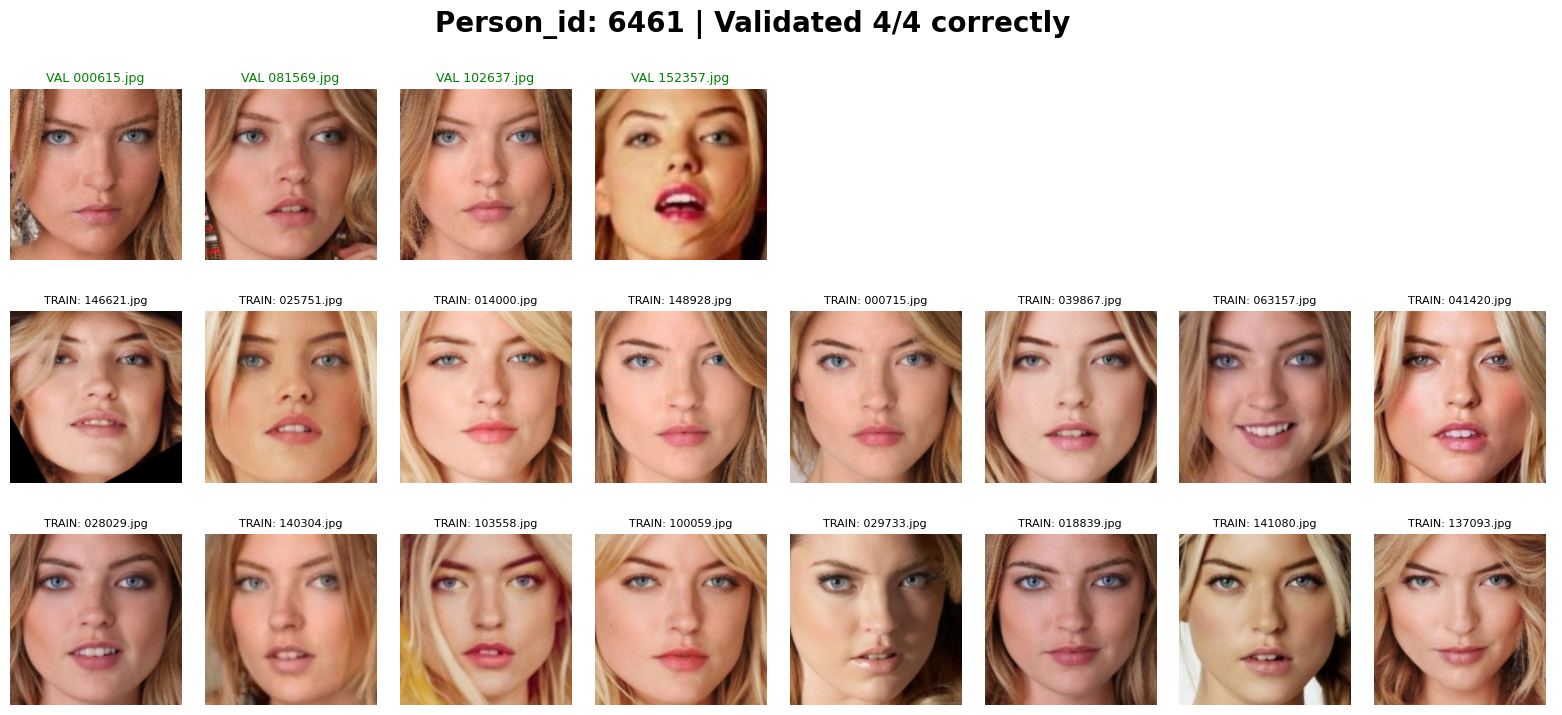

In [ ]:
visualize_person_full_history(val_report_df, 4)

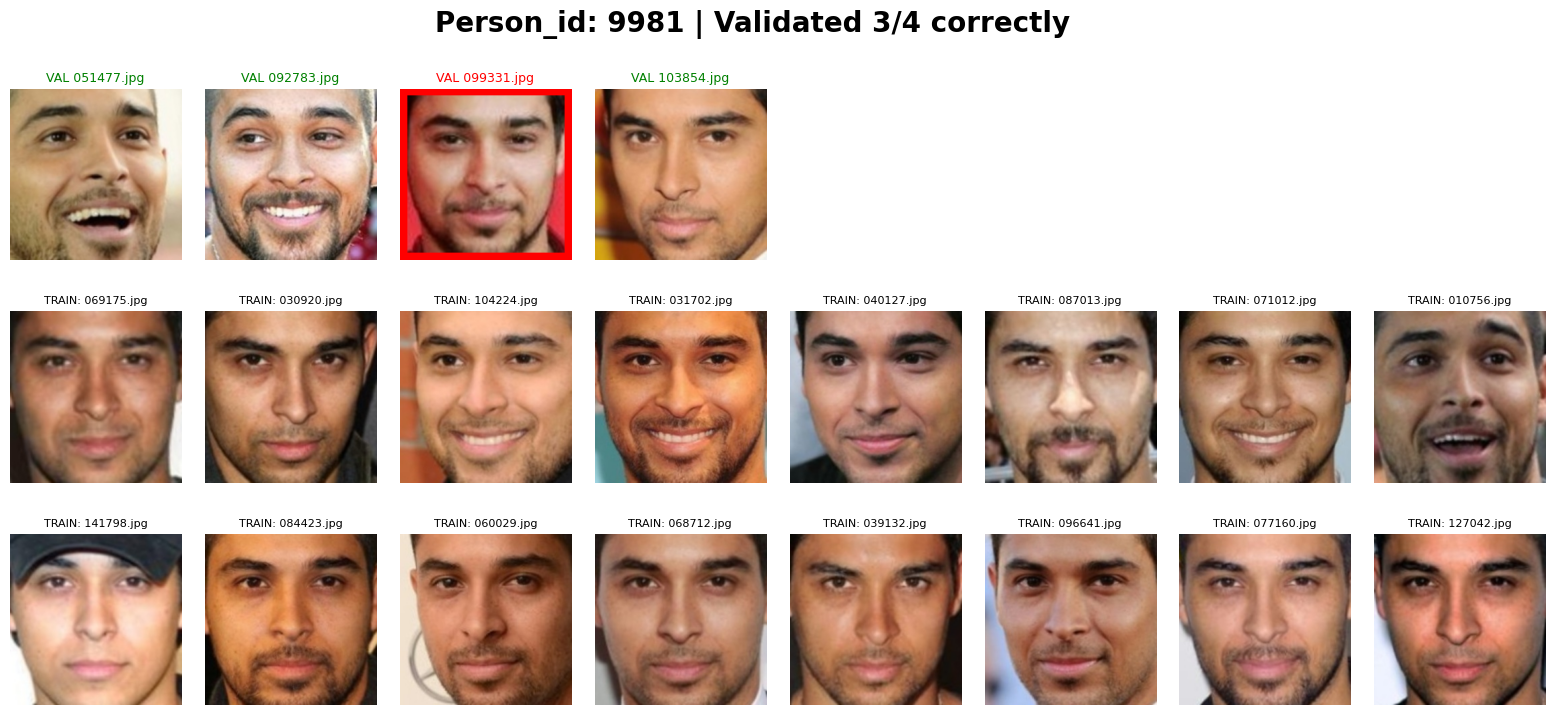

In [ ]:
visualize_person_full_history(val_report_df, 3)

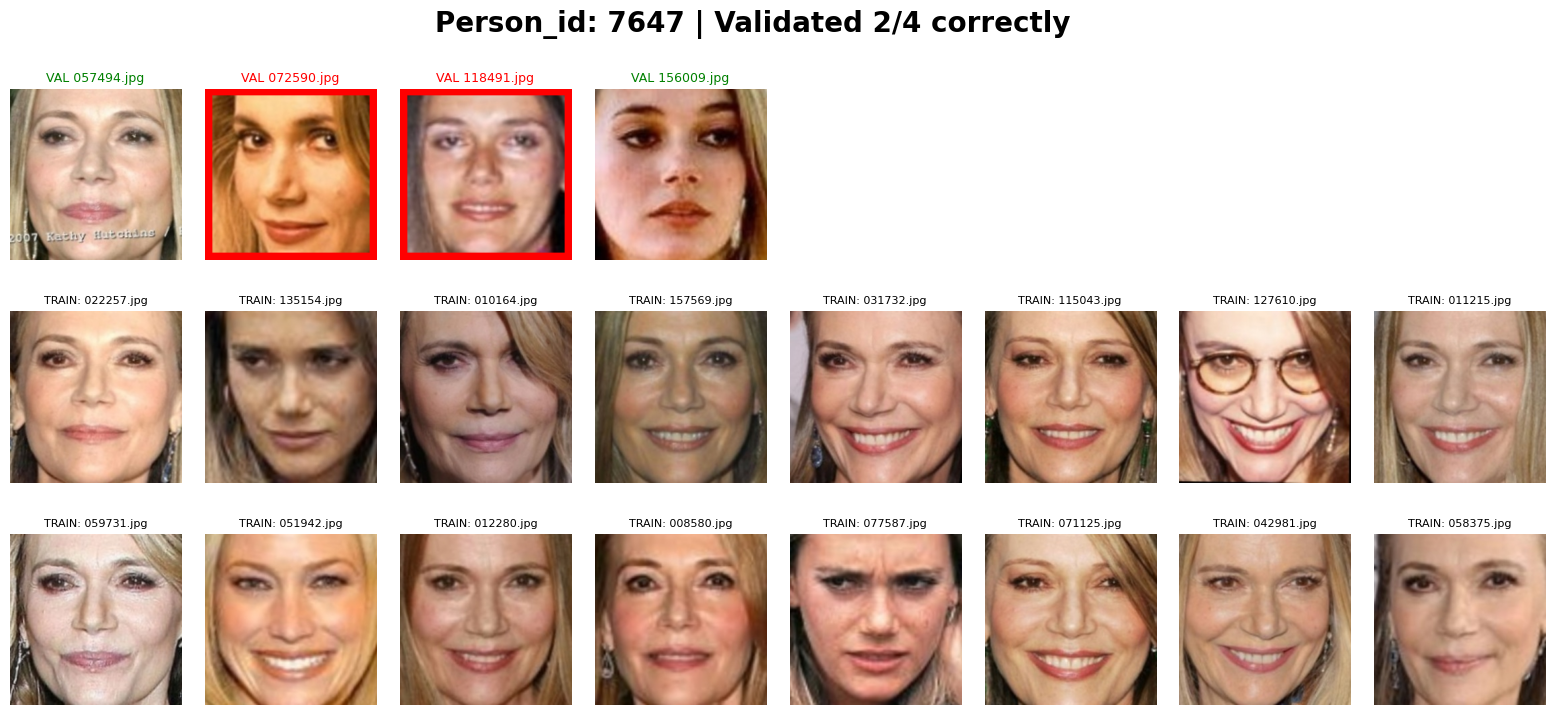

In [ ]:
visualize_person_full_history(val_report_df, 2)

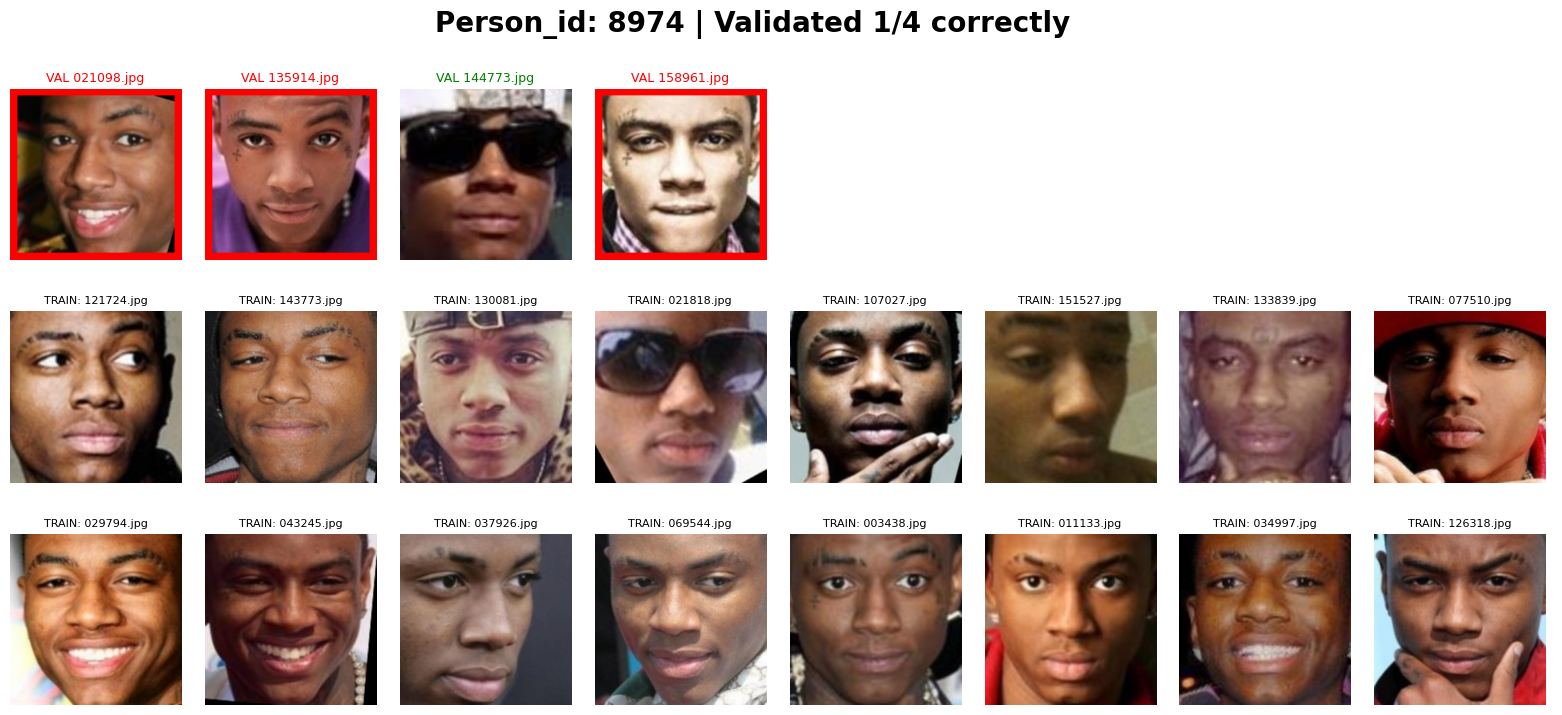

In [ ]:
visualize_person_full_history(val_report_df, 1)

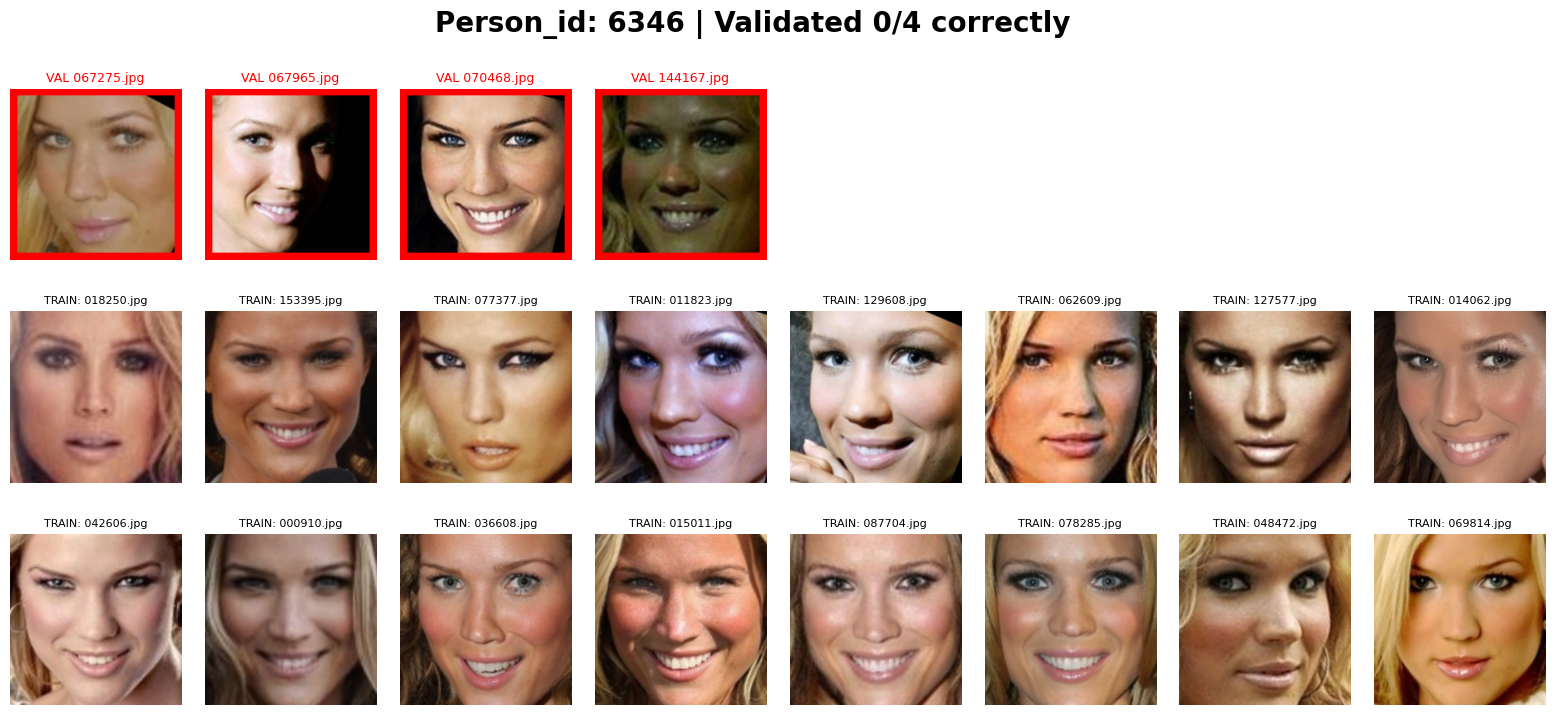

In [ ]:
visualize_person_full_history(val_report_df, 0)

## Шаг 6 "t-SNE визуализация"
* Цель: убедится, что ArcFace слой действительно заставляет группироваться embedding-и, принадлежащие одной персоне (на сфере единичного радиуса в 128-мерном пространстве).
* Преобразуем 128-мерное в 2-мерное пространство и выводим 2000 векторов val выборки.
* Разным цветом выделяем фото случайных 20 из 500 персон, по 4 на персону - все не раскрасить, это понятно. Остальные точки - серые, но видно их расположение.
* Вывод: идеальной группировки достичь не удалось, но математика работает, группируются embedding-и!

In [ ]:
def plot_tsne_with_highlights(embeddings_2d, labels, n_highlights=15):
    # 1. Подготовка данных
    labels = np.array(labels)
    unique_labels = np.unique(labels)

    # Выбираем случайные персоны для выделения цветом
    highlight_labels = random.sample(list(unique_labels), n_highlights)

    plt.figure(figsize=(12, 10))

    # 2. Отрисовка "фоновых" точек (все остальные)
    # Рисуем их первыми, чтобы они были на заднем плане
    background_mask = ~np.isin(labels, highlight_labels)
    plt.scatter(
        embeddings_2d[background_mask, 0],
        embeddings_2d[background_mask, 1],
        c='lightgrey',
        alpha=0.3,
        s=10,
        label='Other labels'
    )

    # 3. Отрисовка выделенных персон
    # Используем качественную цветовую схему
    cmap = plt.get_cmap('tab20')

    for i, p_id in enumerate(highlight_labels):
        mask = labels == p_id
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            color=cmap(i),
            s=50,
            edgecolors='black',
            linewidths=0.5,
            label=f'Label {p_id}'
        )

    plt.title(f't-SNE Visualization of ArcFace Embeddings\n(Highlighted {n_highlights} random persons)', fontsize=15)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

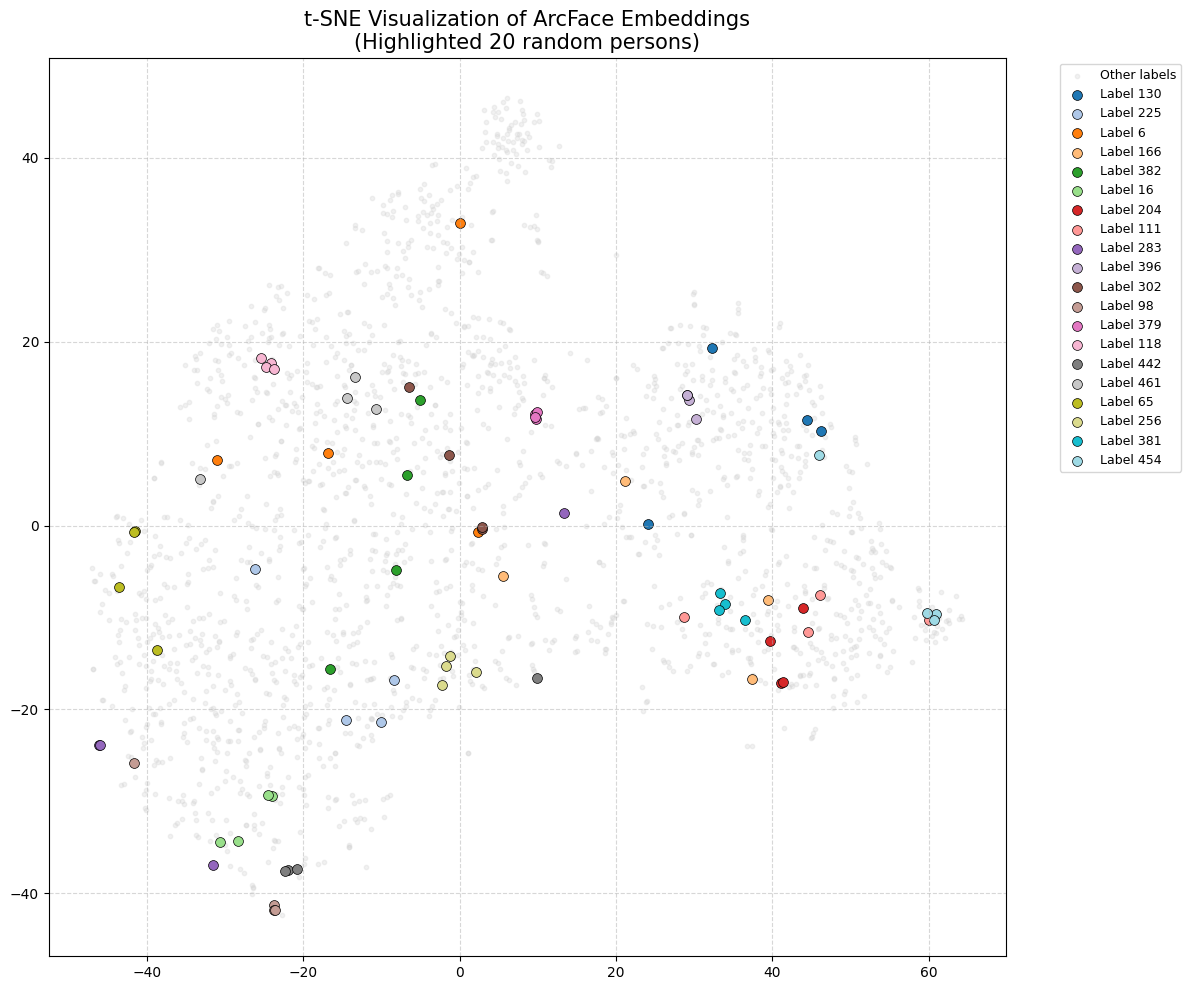

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')

embeddings_2d = tsne.fit_transform(all_embeddings)

plot_tsne_with_highlights(embeddings_2d, all_labels, n_highlights=20)